# Prepare Trained Model for Inference




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime
import torch
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

from luna16 import augmentations, datasets, dto, modules, settings
from luna16.notebooks import visualizations
from luna16.services import ModelSaver

%matplotlib inline

## Load the Trained Model


In [2]:
model_saver = ModelSaver()
model_name = "DropoutModel"
module_params = modules.DropoutParameters(
    name=model_name,
    in_channels=1,
    conv_channels=8,
    out_features=2,
    n_blocks=4,
    input_dim=(32, 48, 48),
    dropout_rate=0.4,
    block_class=modules.DropoutBlock,
)
module_class = modules.CnnModel
model_type = "Classification"
model_version = "1.0.0"
module = model_saver.load_model(
    name=model_type,
    module_class=module_class,
    version=model_version,
    module_params=module_params,
)
module

CnnModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (luna_blocks): ModuleList(
    (0): DropoutBlock(
      (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (dropout1): Dropout(p=0.4, inplace=False)
      (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (dropout2): Dropout(p=0.4, inplace=False)
      (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DropoutBlock(
      (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, tr

## Try on a Sample Image


In [3]:
ratio = dto.NoduleRatio(positive=1, negative=1)
transformations: list[augmentations.Transformation] = [
    augmentations.Flip(),
    augmentations.Offset(offset=0.1),
    augmentations.Scale(scale=0.2),
    augmentations.Rotate(),
]
filters: list[augmentations.Filter] = [
    augmentations.Noise(noise=25.0),
]
dataset = datasets.CutoutsDataset(
    ratio=ratio,
    validation_stride=20,
    transformations=transformations,
    filters=filters,
)

[02/22/25 19:00:40] INFO     CutoutsDataset(len=47499, positive_len=77, negative_len=47422,    ]8;id=270167;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py\nodule_cutouts.py]8;;\:]8;id=12500;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py#95\95]8;;\
                             train=True, validation_stride=20)                                                     

In [4]:
positive_cutout = dataset[0]
negative_cutout = dataset[1]
(
    positive_cutout.candidate.shape,
    negative_cutout.candidate.min(),
    negative_cutout.candidate.max(),
)

(torch.Size([1, 32, 48, 48]), tensor(-999.9697), tensor(287.9218))

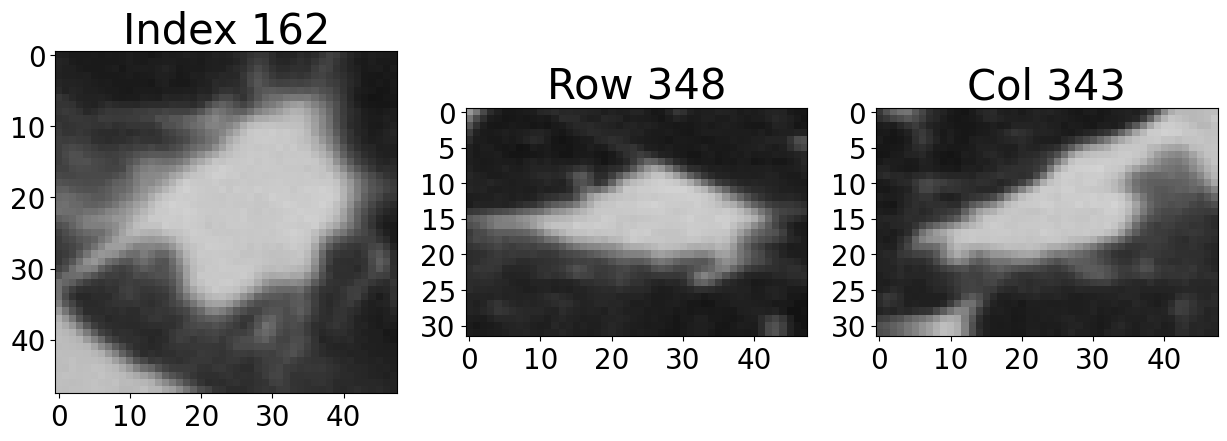

In [5]:
visualizations.plot_cutout(
    positive_cutout.center_irc, positive_cutout.candidate[0].numpy()
)

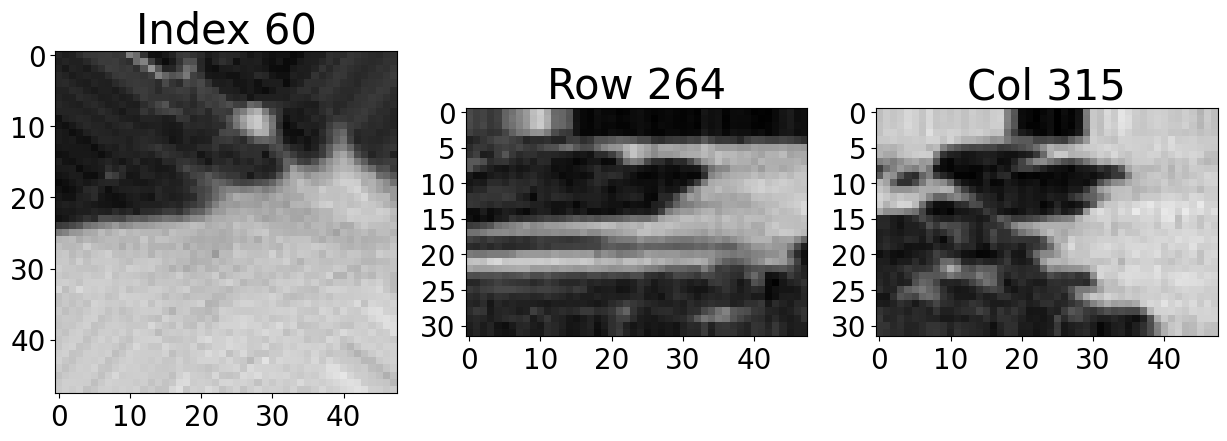

In [6]:
visualizations.plot_cutout(
    negative_cutout.center_irc, negative_cutout.candidate[0].numpy()
)

## Export the Model for Inference

In [7]:
args = (torch.unsqueeze(positive_cutout.candidate, 0),)
compiled_models = settings.MODELS_DIR / "compiled"
compiled_models.mkdir(exist_ok=True)

compiled_model_name = f"{model_type}-{model_name}-{model_version}.onnx"
compiled_model_path = compiled_models / compiled_model_name
torch.onnx.export(
    module,
    args,
    compiled_model_path,
    input_names=["input"],
    output_names=["logits", "probabilities"],
)

## Run Model with ONNX Runtime

In [8]:
session = onnxruntime.InferenceSession(compiled_model_path)
session

We only have one input, the cutout image model will be classifying.

In [9]:
# Get the name of the input node (usually the first input)
input_name = session.get_inputs()[0].name
# Get the expected input shape
input_shape = session.get_inputs()[0].shape
# Get the expected input data type
input_type = session.get_inputs()[0].type

print(f"Input Name: {input_name}")
print(f"Shape: {input_shape}")
print(f"Type: {input_type}")

Input Name: input
Shape: [1, 1, 32, 48, 48]
Type: tensor(float)


Model can output both logits and probabilities. For inference, we will use only probabilities.

In [10]:
output_names = [output.name for output in session.get_outputs()]
output_names

['logits', 'probabilities']

### Inference on Nodule Cutout Image

In [11]:
# Create a dictionary mapping input name to input data
input_feed = {
    input_name: torch.unsqueeze(positive_cutout.candidate, 0).numpy(),
}

In [12]:
outputs = session.run(output_names=["probabilities"], input_feed=input_feed)
outputs

[array([[0.11881696, 0.881183  ]], dtype=float32)]

In [13]:
probabilities = outputs[0]
predicted_class_index = np.argmax(probabilities)
(
    probabilities,
    predicted_class_index,
    "Is Nodule" if predicted_class_index == 1 else "Not Nodule",
)

(array([[0.11881696, 0.881183  ]], dtype=float32), np.int64(1), 'Is Nodule')

### Inference on Not Nodule Cutout Image

In [14]:
input_feed = {
    "input": torch.unsqueeze(negative_cutout.candidate, 0).numpy(),
}
outputs = session.run(output_names=["probabilities"], input_feed=input_feed)
probabilities = outputs[0]
predicted_class_index = np.argmax(probabilities)
(
    probabilities,
    predicted_class_index,
    "Is Nodule" if predicted_class_index == 1 else "Not Nodule",
)

(array([[0.99091023, 0.00908977]], dtype=float32), np.int64(0), 'Not Nodule')

# Classification Threshold

A classification threshold is a cutoff value used to decide the predicted class from a continuous output (often a probability or logit). In binary classification, if the model outputs a probability for the positive class, you typically assign a positive label when that probability exceeds the threshold (commonly 0.5).

You can use the classification threshold to control the sensitivity of your nodule classifier. For example, to classify more cutouts as nodules, you can lower the threshold so that even if the model’s positive probability is a bit lower than before, the image will still be considered a nodule.

In [15]:
input = dataset[22]
input_feed = {
    "input": torch.unsqueeze(input.candidate, 0).numpy(),
}
outputs = session.run(output_names=["probabilities"], input_feed=input_feed)
probabilities = outputs[0]
percents = (probabilities * 100).round(2)
percents

array([[ 0.57, 99.43]], dtype=float32)

In [16]:
for i in range(0, 77 * 2, 2):
    input = dataset[i]
    input_feed = {
        "input": torch.unsqueeze(input.candidate, 0).numpy(),
    }
    outputs = session.run(output_names=["probabilities"], input_feed=input_feed)
    probabilities = outputs[0]
    percents = (probabilities * 100).astype(dtype=int)
    print(percents)

[[ 1 98]]
[[83 16]]
[[ 0 99]]
[[27 72]]
[[ 0 99]]
[[ 0 99]]
[[ 2 97]]
[[35 64]]
[[ 0 99]]
[[ 0 99]]
[[ 4 95]]
[[ 0 99]]
[[ 1 98]]
[[ 0 99]]
[[ 2 97]]
[[ 4 95]]
[[ 0 99]]
[[ 0 99]]
[[ 0 99]]
[[ 1 98]]
[[50 49]]
[[ 0 99]]
[[ 1 98]]
[[ 0 99]]
[[ 1 98]]
[[35 64]]
[[ 0 99]]
[[21 78]]
[[13 86]]
[[ 1 98]]
[[ 0 99]]
[[ 0 99]]
[[ 0 99]]
[[92  7]]
[[ 0 99]]
[[ 1 98]]
[[24 75]]
[[11 88]]
[[ 0 99]]
[[ 0 99]]
[[47 52]]
[[ 2 97]]
[[ 0 99]]
[[27 72]]
[[ 0 99]]
[[45 54]]
[[27 72]]
[[ 0 99]]
[[ 0 99]]
[[ 0 99]]
[[ 0 99]]
[[ 2 97]]
[[ 1 98]]
[[ 1 98]]
[[ 0 99]]
[[38 61]]
[[ 0 99]]
[[ 0 99]]
[[ 4 95]]
[[ 0 99]]
[[ 9 90]]
[[ 0 99]]
[[10 89]]
[[ 0 99]]
[[ 0 99]]
[[16 83]]
[[56 43]]
[[27 72]]
[[54 45]]
[[67 32]]
[[ 0 99]]
[[ 9 90]]
[[76 23]]
[[ 6 93]]
[[18 81]]
[[22 77]]
[[ 0 99]]


In [17]:
def nodule_evaluate_model_threshold(threshold: float) -> tuple[int, int]:
    correct = 0
    incorrect = 0
    for i in range(0, 77 * 2, 2):
        input = dataset[i]
        input_feed = {
            "input": torch.unsqueeze(input.candidate, 0).numpy(),
        }
        outputs = session.run(output_names=["probabilities"], input_feed=input_feed)
        probabilities = outputs[0]
        if probabilities[0][1] > threshold:
            correct += 1
        else:
            incorrect += 1
    return correct, incorrect


def not_nodule_evaluate_model_threshold(threshold: float) -> tuple[int, int]:
    correct = 0
    incorrect = 0
    for i in range(1, 77 * 2, 2):
        input = dataset[i]
        input_feed = {
            "input": torch.unsqueeze(input.candidate, 0).numpy(),
        }
        outputs = session.run(output_names=["probabilities"], input_feed=input_feed)
        probabilities = outputs[0]
        if probabilities[0][1] < threshold:
            correct += 1
        else:
            incorrect += 1
    return correct, incorrect

In [18]:
threshold = 0.5
positive_correct, positive_incorrect = nodule_evaluate_model_threshold(
    threshold=threshold
)
negative_correct, negative_incorrect = not_nodule_evaluate_model_threshold(
    threshold=threshold
)

print(f"Nodule Correct: {positive_correct} Nodule Incorrect: {positive_incorrect}")
print(
    f"Not Nodule Correct: {negative_correct} Not Nodule Incorrect: {negative_incorrect}"
)

Nodule Correct: 71 Nodule Incorrect: 6
Not Nodule Correct: 77 Not Nodule Incorrect: 0


In [19]:
threshold = 0.3
positive_correct, positive_incorrect = nodule_evaluate_model_threshold(
    threshold=threshold
)
negative_correct, negative_incorrect = not_nodule_evaluate_model_threshold(
    threshold=threshold
)

print(f"Nodule Correct: {positive_correct} Nodule Incorrect: {positive_incorrect}")
print(
    f"Not Nodule Correct: {negative_correct} Not Nodule Incorrect: {negative_incorrect}"
)

Nodule Correct: 74 Nodule Incorrect: 3
Not Nodule Correct: 77 Not Nodule Incorrect: 0


In [20]:
threshold = 0.25
positive_correct, positive_incorrect = nodule_evaluate_model_threshold(
    threshold=threshold
)
negative_correct, negative_incorrect = not_nodule_evaluate_model_threshold(
    threshold=threshold
)

print(f"Nodule Correct: {positive_correct} Nodule Incorrect: {positive_incorrect}")
print(
    f"Not Nodule Correct: {negative_correct} Not Nodule Incorrect: {negative_incorrect}"
)

Nodule Correct: 72 Nodule Incorrect: 5
Not Nodule Correct: 75 Not Nodule Incorrect: 2


In [21]:
threshold = 0.15
positive_correct, positive_incorrect = nodule_evaluate_model_threshold(
    threshold=threshold
)
negative_correct, negative_incorrect = not_nodule_evaluate_model_threshold(
    threshold=threshold
)

print(f"Nodule Correct: {positive_correct} Nodule Incorrect: {positive_incorrect}")
print(
    f"Not Nodule Correct: {negative_correct} Not Nodule Incorrect: {negative_incorrect}"
)

Nodule Correct: 77 Nodule Incorrect: 0
Not Nodule Correct: 74 Not Nodule Incorrect: 3


# ROC Curve & PR Curve

In [22]:
predicted_probabilities = []
true_labels = []

for i in range(10000):
    input = dataset[i]
    input_feed = {
        "input": torch.unsqueeze(input.candidate, 0).numpy(),
    }
    outputs = session.run(output_names=["probabilities"], input_feed=input_feed)
    probability = outputs[0][0][1]
    label = input.labels[1]

    predicted_probabilities.append(probability)
    true_labels.append(label)

## ROC Curve

In [23]:
fpr, tpr, thresholds_roc = roc_curve(true_labels, predicted_probabilities)
auc_roc = roc_auc_score(true_labels, predicted_probabilities)

In [24]:
j_statistic = tpr - fpr
optimal_idx_roc = np.argmax(j_statistic)
optimal_threshold_roc = thresholds_roc[optimal_idx_roc]
optimal_coords = fpr[optimal_idx_roc], tpr[optimal_idx_roc]
print(f"Optimal threshold for ROC curve (Youden's J): {optimal_threshold_roc:.3f}")

Optimal threshold for ROC curve (Youden's J): 0.231


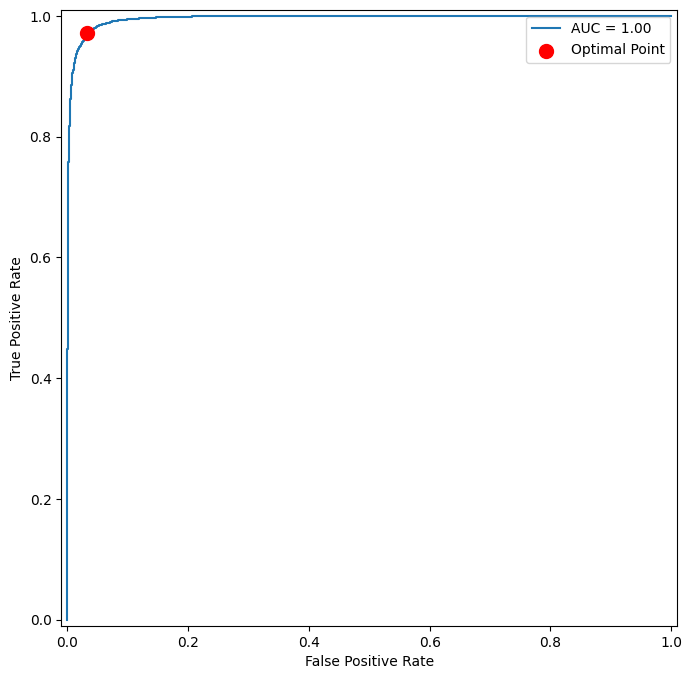

In [25]:
# Plot ROC curve and add the optimal point
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax)

# Add the optimal point using optimal_coords: (fpr, tpr)
ax.scatter(
    optimal_coords[0],
    optimal_coords[1],
    color="red",
    s=100,
    zorder=5,
    label="Optimal Point",
)
ax.legend()

## PR Curve

In [26]:
precision, recall, thresholds_pr = precision_recall_curve(
    true_labels, predicted_probabilities
)
ap_pr = average_precision_score(true_labels, predicted_probabilities)

In [27]:
distances_pr = np.sqrt((1 - precision) ** 2 + (1 - recall) ** 2)
optimal_idx_pr = np.argmin(distances_pr)
# thresholds_pr is one element shorter than precision and recall, might need to adjust
optimal_threshold_pr = thresholds_pr[optimal_idx_pr]
optimal_coords = recall[optimal_idx_pr], precision[optimal_idx_pr]
print(
    f"Optimal threshold for PR curve (closest to top-right): {optimal_threshold_pr:.3f}"
)

Optimal threshold for PR curve (closest to top-right): 0.231


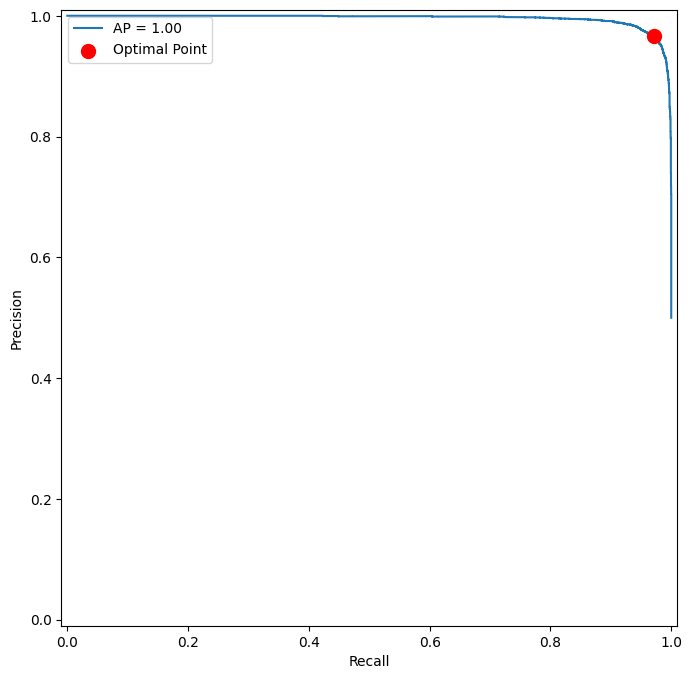

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

pr_display = PrecisionRecallDisplay(
    precision=precision, recall=recall, average_precision=ap_pr
)
pr_display.plot(ax)

# Add the optimal point using optimal_coords: (recall, precision)
ax.scatter(
    optimal_coords[0],
    optimal_coords[1],
    color="red",
    s=100,
    zorder=5,
    label="Optimal Point",
)
ax.legend()

## F1 Score

In [29]:
f1_scores = []
thresholds_f1 = np.linspace(0, 1, 100)  # Example thresholds
for thresh in thresholds_f1:
    predicted_classes = (predicted_probabilities >= thresh).astype(int)
    f1 = f1_score(true_labels, predicted_classes)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds_f1[optimal_idx_f1]
print(f"Optimal threshold for F1-Score: {optimal_threshold_f1:.3f}")

Optimal threshold for F1-Score: 0.232


## Evaluate on F1 Score

In [42]:
def evaluate_threshold_on_f1_score(threshold: np.float32) -> None:
    predicted_classes_optimal = (predicted_probabilities >= threshold).astype(int)
    f1_optimal = f1_score(true_labels, predicted_classes_optimal)
    print(f"F1-Score at threshold {threshold:.3f} in {f1_optimal:.3f}")

In [43]:
original_threshold = np.float32(0.5)
evaluate_threshold_on_f1_score(threshold=original_threshold)

F1-Score at threshold 0.500 in 0.946


In [44]:
evaluate_threshold_on_f1_score(threshold=optimal_threshold_roc)

F1-Score at threshold 0.231 in 0.969


In [45]:
evaluate_threshold_on_f1_score(threshold=optimal_threshold_pr)

F1-Score at threshold 0.231 in 0.969


In [46]:
evaluate_threshold_on_f1_score(threshold=optimal_threshold_f1)

F1-Score at threshold 0.232 in 0.969
